In [1]:
#Generated TH2F files live here:

## This dude has 50 events:
simulated_path = "/exp/dune/data/users/mking/ICEBERG_Noise_Ar_39/iceberg_noise/AR_39_sim/10_02_2024/Waveforms_Sim.root"

## This dude has 1000 events:
#Check these ones:
simulated_path = "/exp/dune/data/users/mking/ICEBERG_Noise_Ar_39/iceberg_noise/AR_39_sim/01_24_2025/Waveforms_Sim.root"

## 1000 events, doped with extra Ar39
simulated_path = "/exp/dune/data/users/mking/ICEBERG_Noise_Ar_39/iceberg_noise/AR_39_sim/01_24_2025/Waveforms_Sim.root"


In [2]:
!pip install uproot
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
## Let's start by opening up the data, picking an event with ar-39, and plotting some waveforms with the ar-39 signal overlayed with Ar-39 plus noise
import uproot
import numpy as np
import matplotlib.pyplot as plt
from Analyzer import Analyzer as Analyzer
import gc

In [4]:
## Data structure:
## (Nevents,channel,timetick) e.g. (1000,1280,2128) arrays.
## Break up into waveforms of length 200. -> (10000, 1280,200)
## Save into 10 npz files of (10000, 1280,200)
## Recall that FEMB 8 is redundant with FEMB 1 -- eliminate channels from FEMB 8

#Fill in these zero channels (FEMB 8) with FEMB 1, arbitrarily
#AverageFFTNoCosmics_mV_Filled[280:320] = AverageFFTNoCosmics_mV[160:200] U
#AverageFFTNoCosmics_mV_Filled[680:720] = AverageFFTNoCosmics_mV[400:440] V
#AverageFFTNoCosmics_mV_Filled[1136:1184] = AverageFFTNoCosmics_mV[800:848] Z

In [5]:
## Only bother saving wires with any signal in them. Only save slice of 200 wires with signal in them.
## Save some of the non-signal noise for training the ROI finder.
## Put appropriate sig/daq pairs into buckets of (n_samples,channel,200)
## n_samples is dynamic, so array is only rectangular in the last 2 indices.

In [6]:
infile = uproot.open(simulated_path)
#print(infile.keys())

In [7]:
## The below are to test one event ##

In [8]:
Noise_key = infile.keys()[0]
Ar39_key = infile.keys()[1]

In [9]:
Noise, xedges, yedges = infile[Noise_key].to_numpy()
Ar39, xedges, yedges = infile[Ar39_key].to_numpy()

xcenters = Analyzer.EdgesToCenters(xedges)
timeticks = yedges[:-1]

In [10]:
print(Noise.shape)
print(Ar39.shape)
print(Noise.dtype)
print(Ar39.dtype)
print(Noise.nbytes/(1024**2)) #noise in 
print(Ar39.nbytes/(1024**2)) #noise in MB
print(2128*1280*4/(1024**2))


(1280, 2128)
(1280, 2128)
float32
float32
10.390625
10.390625
10.390625


(1280,)
(1280,)
[0. 0. 0. ... 0. 0. 0.]


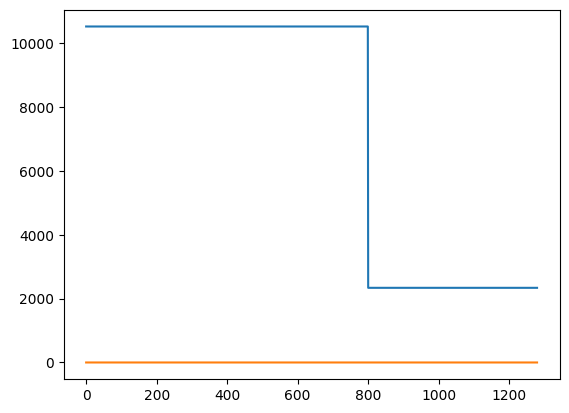

In [11]:
## Baseline subtract channel-by-channel
AvgNoise = np.mean(Noise,axis = 1)
print(AvgNoise.shape)
plt.plot(AvgNoise)
Noise_baseline_sbtr = Noise - AvgNoise[:,np.newaxis]

AvgAr39 = np.mean(Ar39,axis = 1)
print(AvgAr39.shape)
plt.plot(AvgAr39)
Ar39_baseline_sbtr = Ar39 - AvgAr39[:,np.newaxis]
print(AvgAr39)

In [12]:
## True if any element of the array is nonzero
print(np.any(Ar39))

False


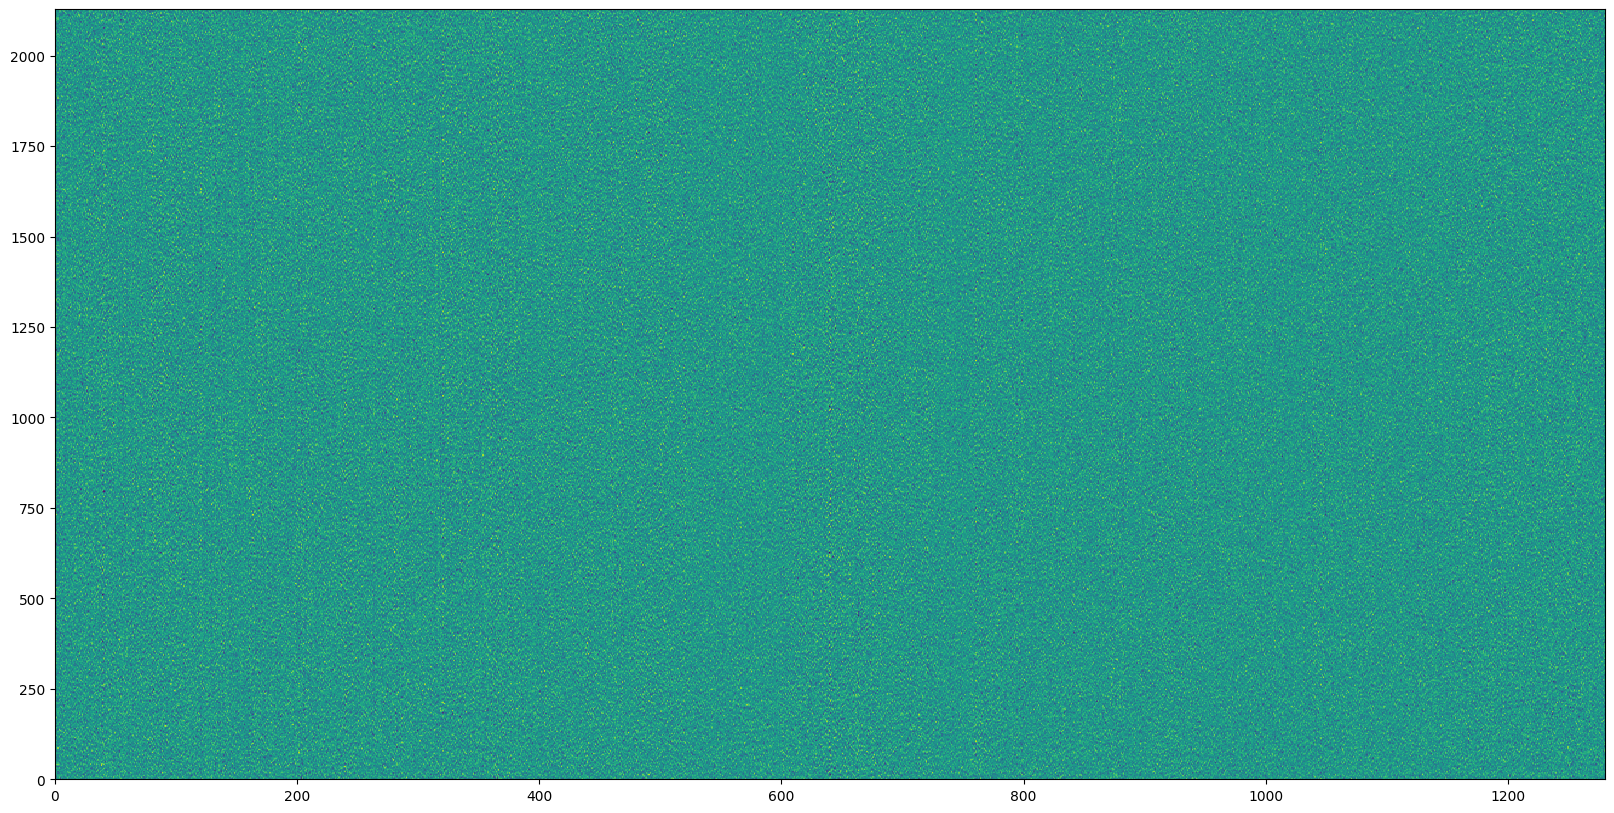

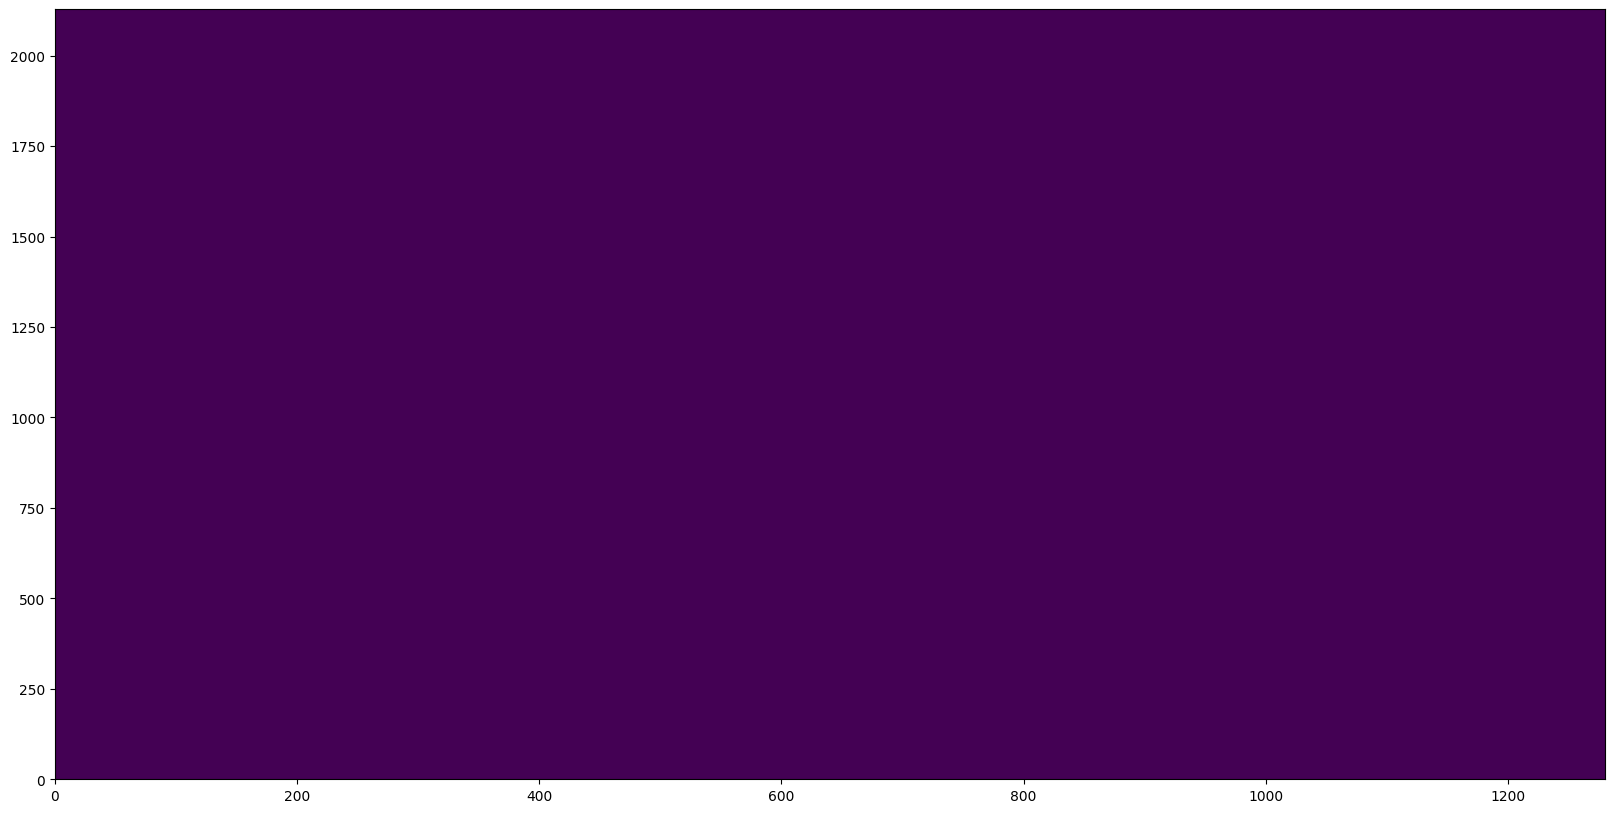

In [13]:
Analyzer.Plot2DWaveform(Noise_baseline_sbtr, xedges, yedges)
Analyzer.Plot2DWaveform(Ar39_baseline_sbtr, xedges, yedges)

In [14]:
#Now to process a bunch of events at once:

In [8]:
H, W = 1280, 2128
num_arrays = 1000

Ar39s = np.memmap("signal.raw", dtype=np.float32, mode='w+', shape=(num_arrays, H, W))

for i in range(int(len(infile.keys())/2)):
    if (i%100 == 0):
        print(i)
    Ar39_key = infile.keys()[2*i+1]
    Ar39s[i]=(infile[Ar39_key].to_numpy()[0])

0
100
200
300
400
500
600
700
800
900


In [13]:
# Assume each numpy array has shape (H, W)
Noises = np.memmap("noise.raw", dtype=np.float32, mode='w+', shape=(num_arrays, H, W))

for i in range(int(len(infile.keys())/2)):
    if (i%100 == 0):
        print(i)
    Noise_key = infile.keys()[2*i]
    #Baseline subtract the average of that event along each channel, after subtracting out the Ar39 signal
    Noises[i]=(infile[Noise_key].to_numpy()[0])-np.mean(infile[Noise_key].to_numpy()[0]-Ar39s[i],axis=1)[:,np.newaxis]

Noises.flush()
del Noises
del Ar39s

infile.close()
del infile
gc.collect() 


0
100
200
300
400
500
600
700
800
900


45687

In [ ]:
#Now that npy files have been created, start here:
import numpy as np
import matplotlib.pyplot as plt
from Analyzer import Analyzer as Analyzer
import gc

In [9]:
# Load the memmap files
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))

# Define ROI: Mark 1 where signal is nonzero, else 0
ROI = (signal_memmap!=0).astype(np.uint8)
np.save("roi.npy", ROI.astype(np.uint8))

print(np.all(signal_memmap ==0 ))
print(np.all(ROI==0))

#del noise_memmap, signal_memmap

False
False


NameError: name 'EventsWithAr39' is not defined

In [18]:
ThisGoodEventIndex = EventsWithAr39[0]
ThisAr39 = signal_memmap[ThisGoodEventIndex]
print(np.shape(ThisAr39))
print(np.nonzero(ThisAr39))

ThisROI = ROI[ThisGoodEventIndex]
print(np.nonzero(ThisROI))
print(np.array_equal(np.nonzero(ThisAr39) , np.nonzero(ThisROI)))

(1280, 2128)
(array([139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 536, 536, 536,
       537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537,
       537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 538,
       538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 539, 540,
       540, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541,
       915, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916,
       916, 916, 916, 916, 917, 917, 917, 917, 917, 917, 917, 917, 917,
       917, 917, 917, 917, 917, 917, 917, 918, 918, 921, 921, 921, 921,
       921, 921, 921, 921, 921, 921, 921]), array([1354, 1355, 1356, 1357, 1358, 1361, 1362, 1363, 1364, 1365, 1366,
       1350, 1351, 1352, 1353, 1354, 1355, 1356, 1358, 1359, 1360, 1361,
    

In [57]:
del ROI

In [62]:
ROI = np.memmap("roi.npy", dtype=np.uint8, mode='r', shape=(1000, 1280, 2128))
ROI2 = np.load("roi.npy")

ThisROI = ROI[ThisGoodEventIndex]
print(np.nonzero(ThisROI))

ThisROI2 = ROI2[ThisGoodEventIndex]
print(np.nonzero(ThisROI2))

(array([139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 536, 536, 536,
       537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537,
       537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 538,
       538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 539, 540,
       540, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541,
       915, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916,
       916, 916, 916, 916, 917, 917, 917, 917, 917, 917, 917, 917, 917,
       917, 917, 917, 917, 917, 917, 917, 918, 918, 921, 921, 921, 921,
       921, 921, 921, 921, 921, 921, 921]), array([1514, 1515, 1516, 1517, 1518, 1521, 1522, 1523, 1524, 1525, 1526,
       1510, 1511, 1512, 1513, 1514, 1515, 1516, 1518, 1519, 1520, 1521,
       1522, 1523

In [11]:
#Now search through our 1000 events of Ar39 and establish which ones contain any signal
#Ar39s = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))

count = 0
EventsWithAr39 = []
for i in range(len(signal_memmap)):
    if np.any(signal_memmap[i]):
        count = count+1
        EventsWithAr39.append(i)

print(count)

601


In [ ]:
from Analyzer import Analyzer as Analyzer
xedges = np.arange(1281)
yedges = np.arange(2129)
Analyzer.Plot2DWaveform(np.log(ThisAr39), xedges, yedges)

In [ ]:
#Go from here for checks

In [14]:
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
ROI = np.load("roi.npy")

In [15]:
count = 0
EventsWithAr39 = []
for i in range(len(signal_memmap)):
    if np.any(signal_memmap[i]):
        count = count+1
        EventsWithAr39.append(i)

print(count)

601


In [18]:
#Investigate a single event and plot its signal and noise
ThisGoodEventIndex = EventsWithAr39[0]
ThisAr39 = signal_memmap[ThisGoodEventIndex]
print(np.shape(ThisAr39))
print(np.nonzero(ThisAr39))

ThisROI = ROI[ThisGoodEventIndex]
print(np.nonzero(ThisROI))

(1280, 2128)
(array([139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143,
       143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 536, 536, 536,
       537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537,
       537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 538,
       538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 539, 540,
       540, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541,
       915, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916,
       916, 916, 916, 916, 917, 917, 917, 917, 917, 917, 917, 917, 917,
       917, 917, 917, 917, 917, 917, 917, 918, 918, 921, 921, 921, 921,
       921, 921, 921, 921, 921, 921, 921]), array([1354, 1355, 1356, 1357, 1358, 1361, 1362, 1363, 1364, 1365, 1366,
       1350, 1351, 1352, 1353, 1354, 1355, 1356, 1358, 1359, 1360, 1361,
    

In [19]:
#grab the rows 
Rows_With_signal= np.unique(np.nonzero(ThisAr39)[0])
print(Rows_With_signal)

[139 142 143 144 536 537 538 539 540 541 915 916 917 918 921]


In [20]:
#Get the noise for this event and background subtract
ThisNoise = noise_memmap[ThisGoodEventIndex]
#Already baseline subtracted now
#AvgNoise = np.mean(ThisNoise-ThisAr39,axis = 1) #Noise is really Noise + Ar39
#Noise_baseline_sbtr = ThisNoise - AvgNoise[:,np.newaxis]

In [44]:
print(np.all(ROI ==0))

False


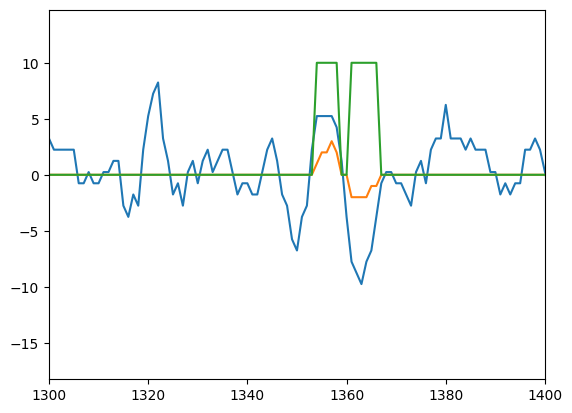

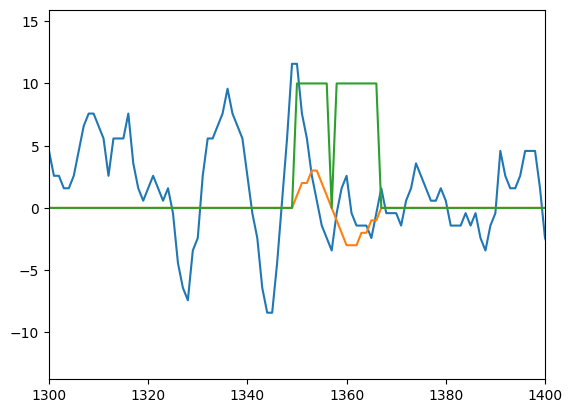

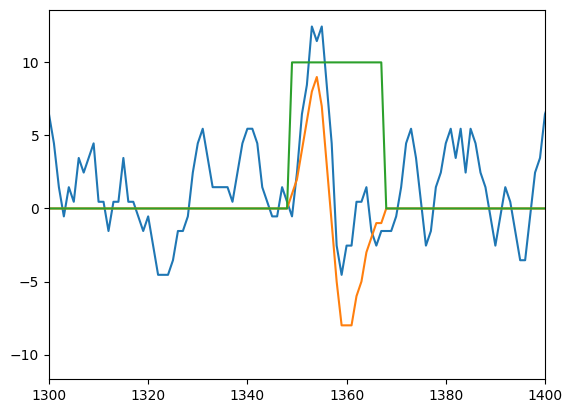

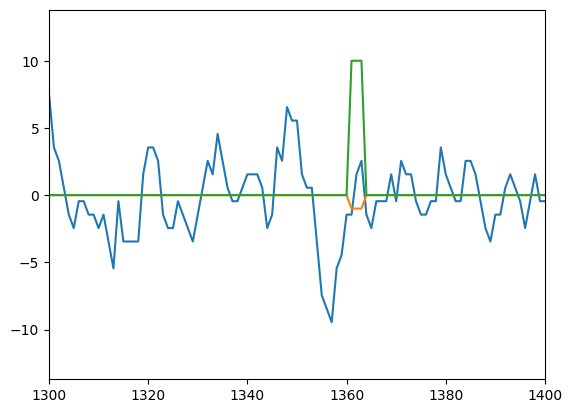

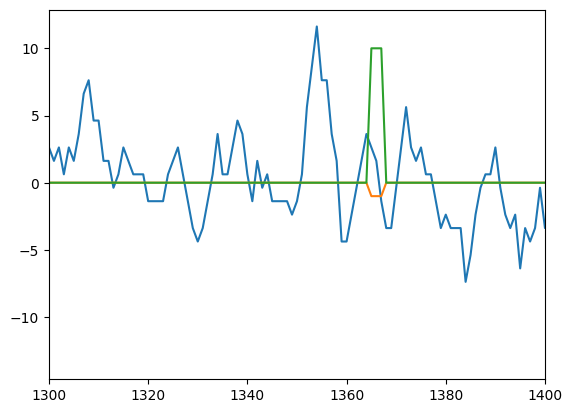

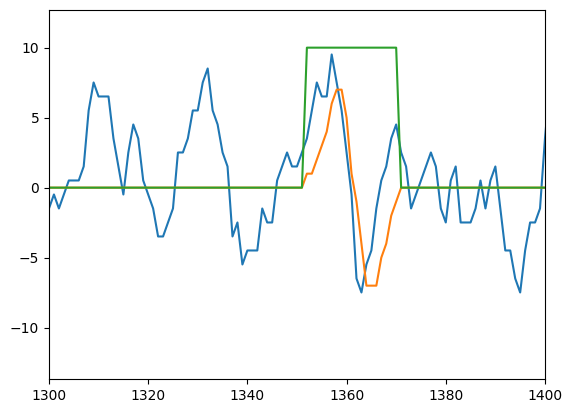

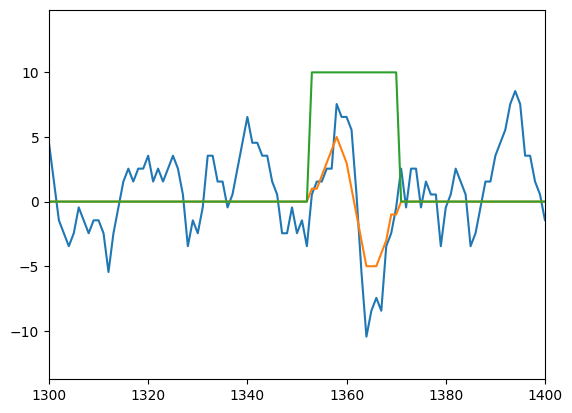

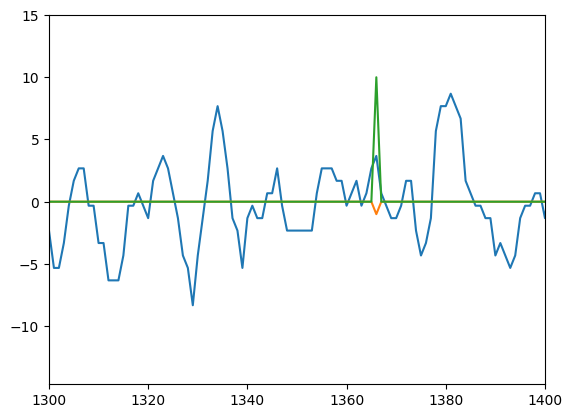

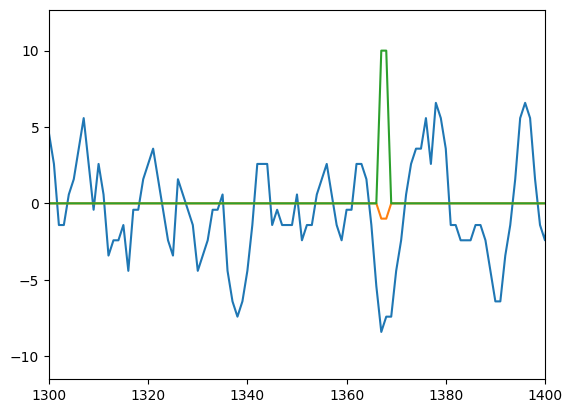

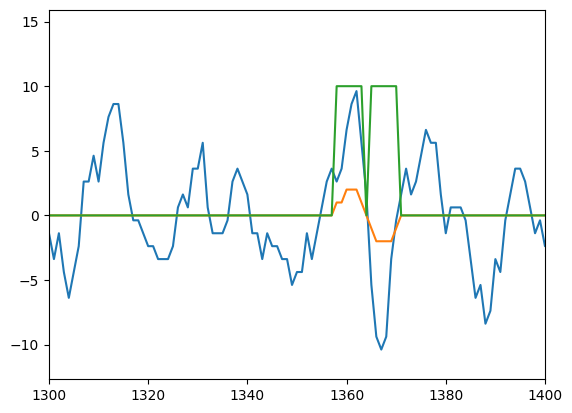

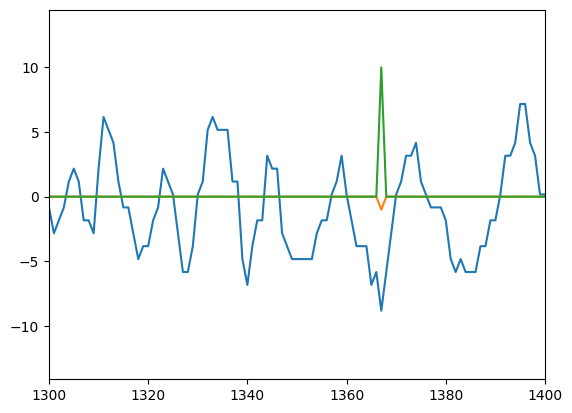

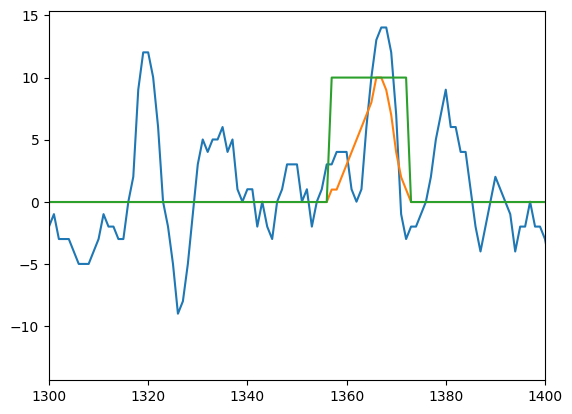

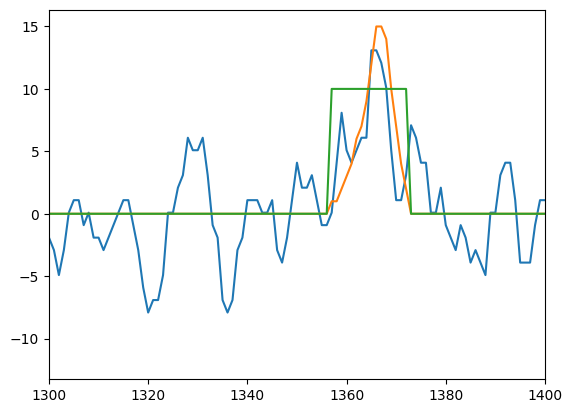

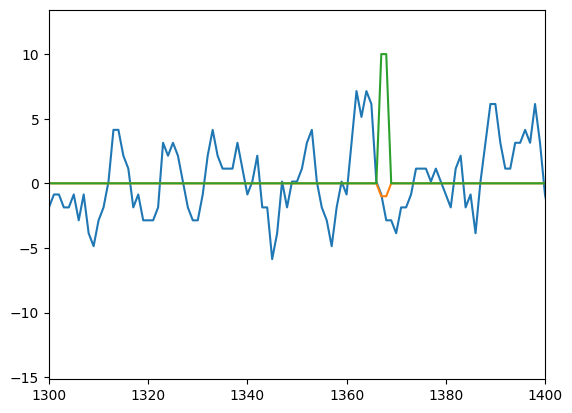

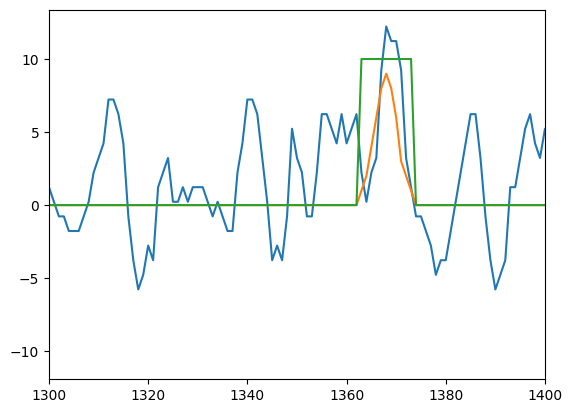

In [21]:
for row in Rows_With_signal:
    plt.figure()
    plt.xlim(1300,1400)
    plt.plot(ThisNoise[row]) #checking overlays
    plt.plot(ThisAr39[row])
    plt.plot(ThisROI[row]*10)

In [ ]:
#Not encouraging... Can I make a plot (plane separated) of the maximum ADC values for the Ar-39 on a given channel?
#If it lies below the noise RMS for each channel, may need time-correlations from the get-go.
#Maybe a better plot is the maximum ADC on each plane, since the blips may span a couple of wires
#Multiplane matching could certainly help

In [ ]:
#For each of the EventsWithAr39, sort into the 6 planes. Store maximum ADC value for each event for each plane
# Geometry:
# SortedArray[0][0][0:200] = MegaArray[0:200]     #TPC 0 Plane u
#        SortedArray[1][0][0:200] = MegaArray[200:400]   #TPC 1 Plane u
#        SortedArray[0][1][0:200] = MegaArray[400:600]   #TPC 0 Plane v
#        SortedArray[1][1][0:200] = MegaArray[600:800]   #TPC 1 Plane v
#        SortedArray[0][2]        = MegaArray[800:1040]  #TPC 0 Plane z
#        SortedArray[1][2]        = MegaArray[1040:1280] #TPC 1 Plane z

#Make a 2D array...

#Start with Z plane
#use integral instead of max
# max to compare with noise

#Fill below with 3-tuples corresponding to MaxADC value for (u,v,z)
MaxADCAr39TPC0 = []
MaxADCAr39TPC1 = []

for iEvent in EventsWithAr39:
    ThisAr39 = Ar39s[iEvent]
    #First decide which TPC the ar-39 is in, then take the maximum ADC value across each plane
    
    

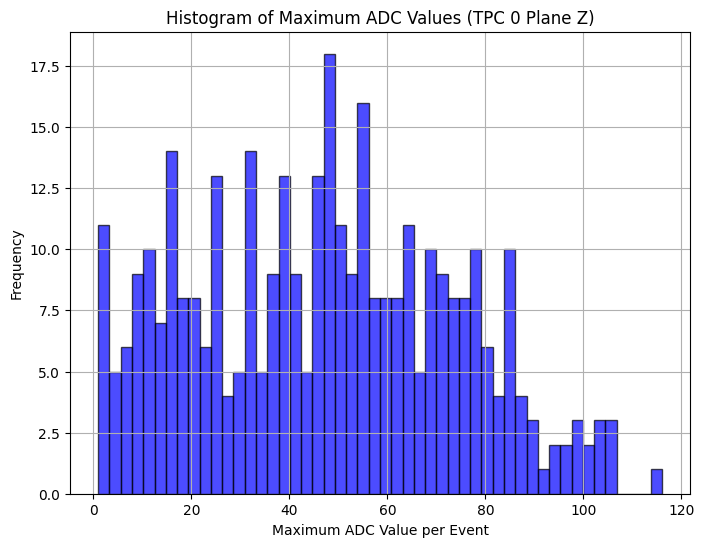

110
125


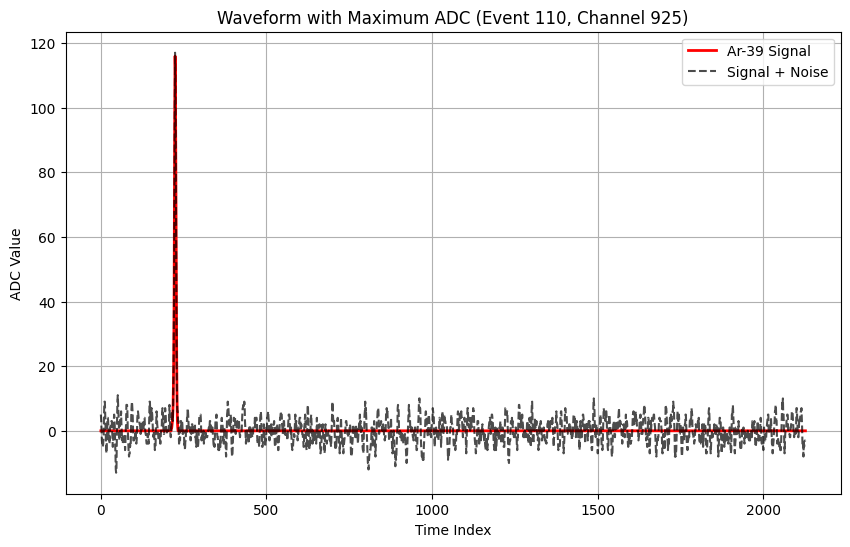

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load memmap files
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
ROI = np.load("roi.npy")

# Extract TPC 0 Plane Z (channels 800-1039)
signal_data = signal_memmap[:, 800:1040, :]
noise_data = noise_memmap[:, 800:1040, :]
ROI_data = ROI[:,800:1040, :]

# Find the maximum ADC of any waveform in each event
max_adc_per_event = np.max(signal_data, axis=(1, 2))  # Max ADC per event

# Filter out events where max ADC is 0
nonzero_max_adc = max_adc_per_event[max_adc_per_event > 0]

# Plot histogram of maximum ADC values
plt.figure(figsize=(8, 6))
plt.hist(nonzero_max_adc, bins=50, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Maximum ADC Value per Event")
plt.ylabel("Frequency")
plt.title("Histogram of Maximum ADC Values (TPC 0 Plane Z)")
plt.grid(True)
plt.show()

# Find the event and channel with the global maximum ADC
event_idx, channel_idx, _ = np.unravel_index(np.argmax(signal_data), signal_data.shape)

# Extract the corresponding signal and noise waveforms
signal_waveform = signal_data[event_idx, channel_idx, :]
noise_waveform = noise_data[event_idx, channel_idx, :]

print(event_idx)
print(channel_idx)
# Plot signal overlaid on noise
plt.figure(figsize=(10, 6))
plt.plot(signal_waveform, label="Ar-39 Signal", color='r', linewidth=2)
plt.plot(noise_waveform, label="Signal + Noise", color='k', linestyle='dashed', alpha=0.7)
#plt.plot(ROI_data[event_idx,channel_idx,:]*100, label="ROI", color='g')
plt.xlabel("Time Index")
plt.ylabel("ADC Value")
plt.title(f"Waveform with Maximum ADC (Event {event_idx}, Channel {channel_idx + 800})")
plt.legend()
plt.grid(True)
plt.show()

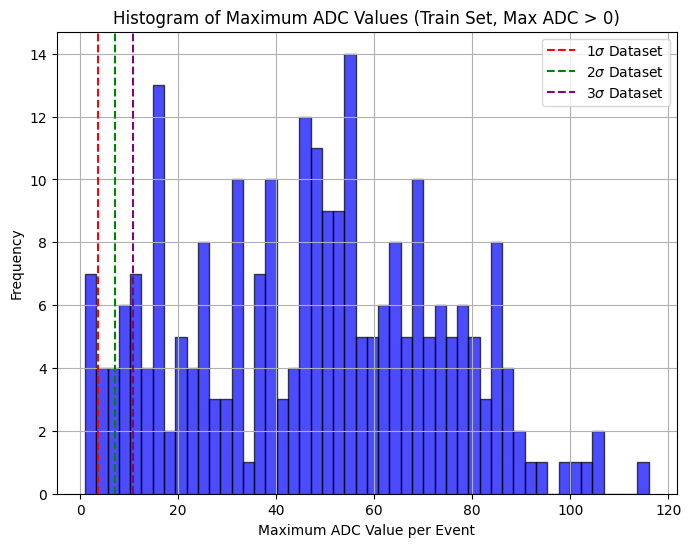

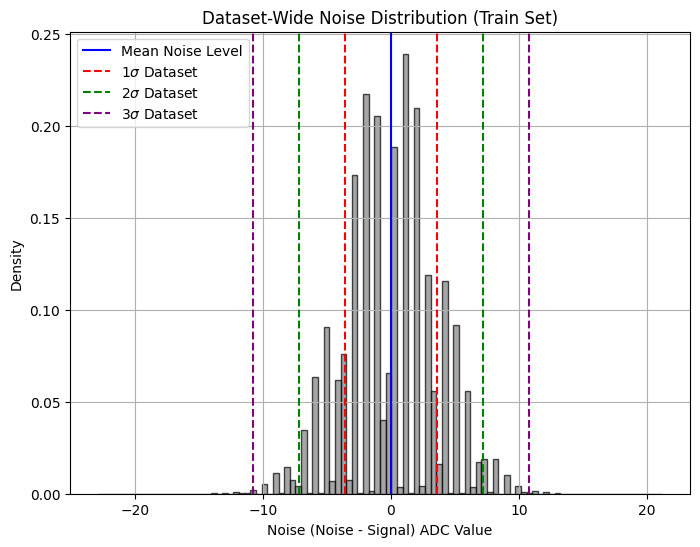

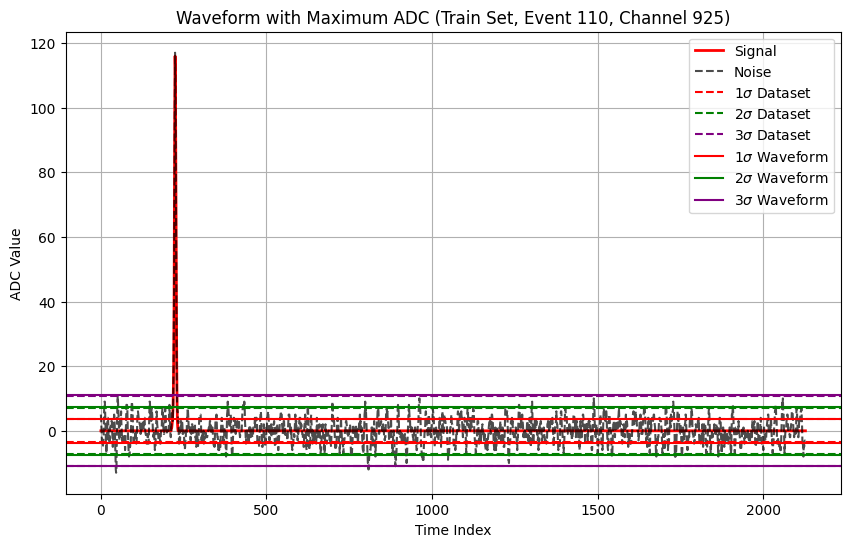

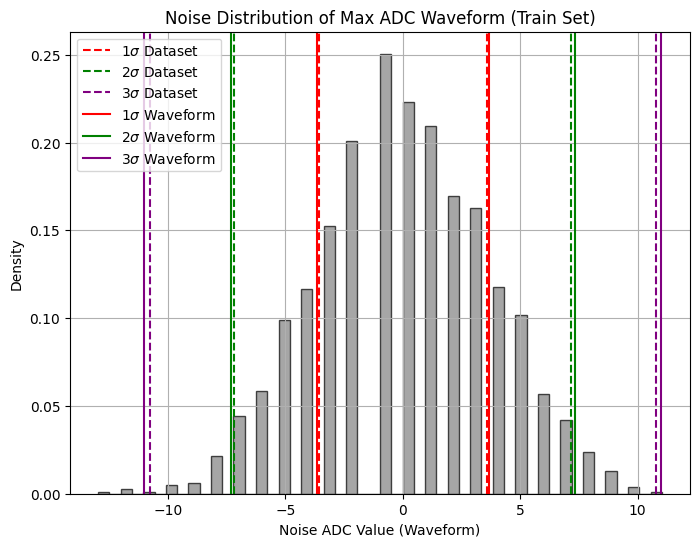

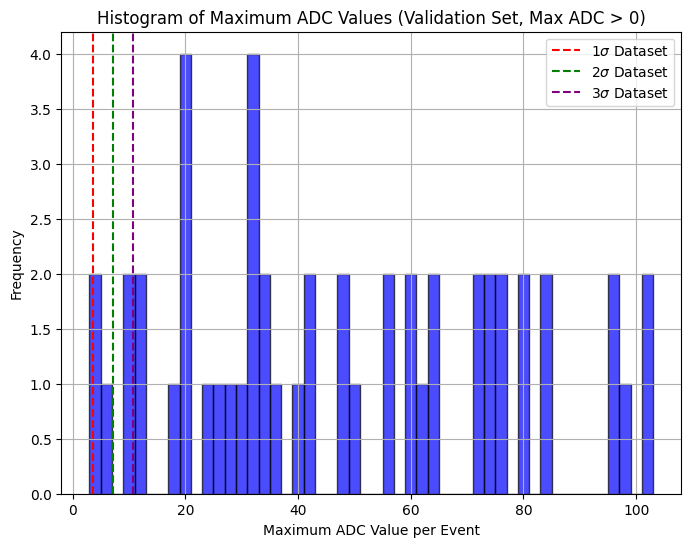

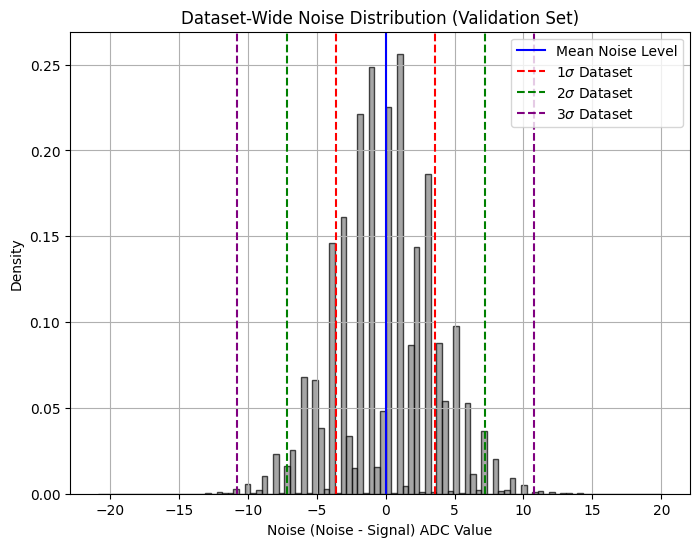

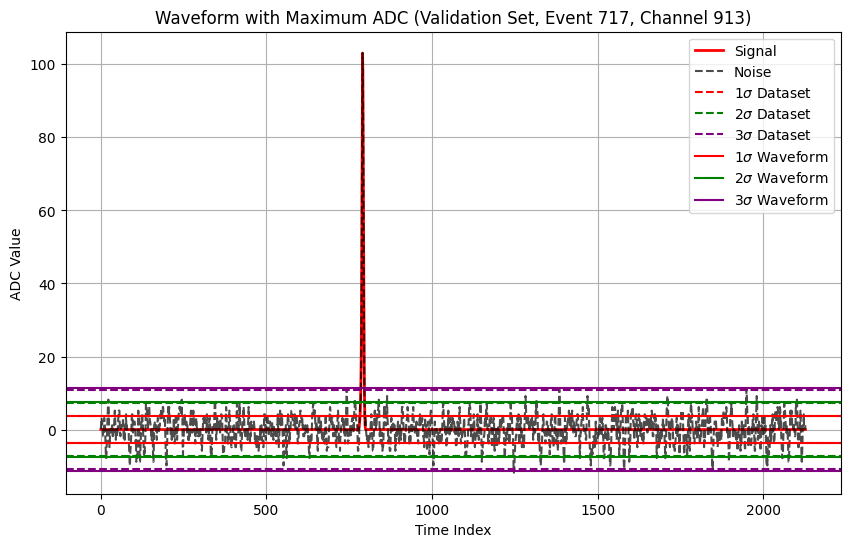

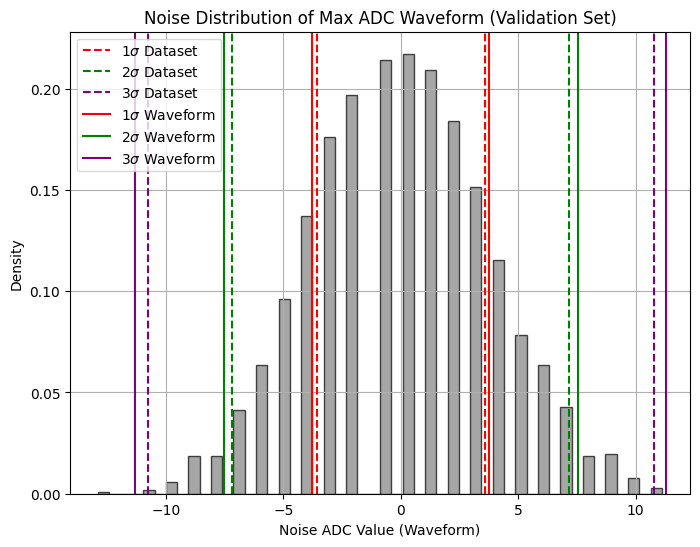

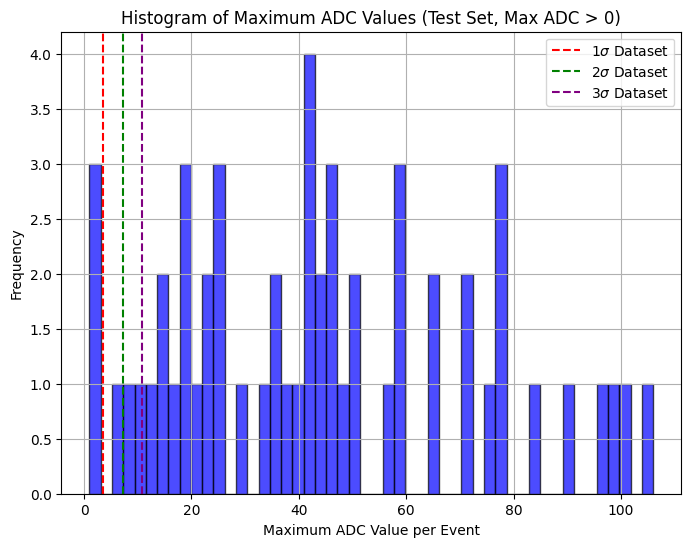

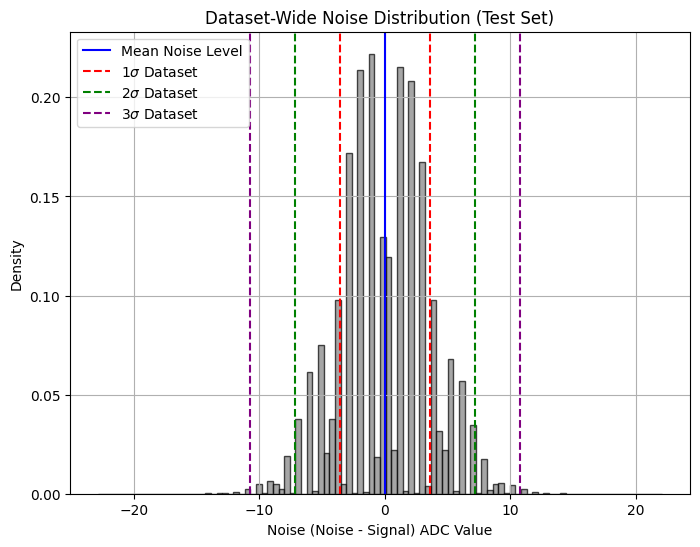

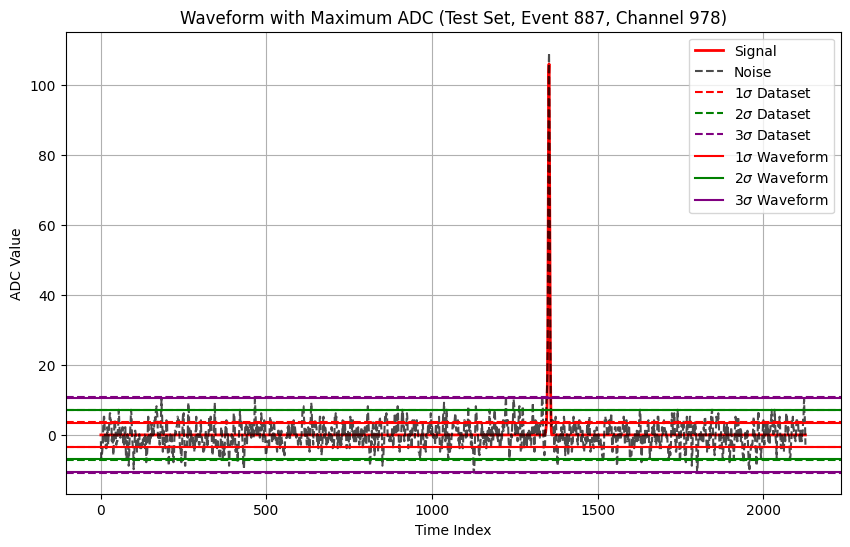

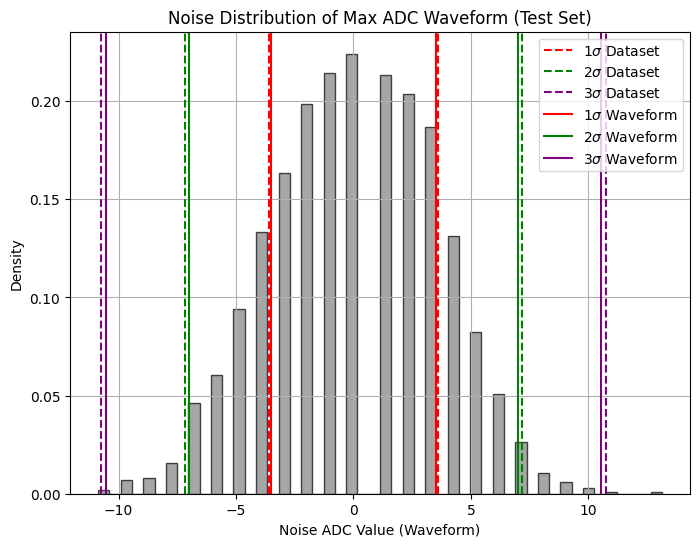

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Load memmap files
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))

# Extract TPC 0 Plane Z (channels 800-1039)
signal_data = signal_memmap[:, 800:1040, :]
noise_data = noise_memmap[:, 800:1040, :]

# Compute noise distribution (Noise - Signal)
noise_distribution = noise_data - signal_data  # This is the actual noise

# Split into train (70%), validation (15%), test (15%)
num_events = signal_data.shape[0]
train_size = int(0.7 * num_events)
val_size = int(0.15 * num_events)
test_size = num_events - train_size - val_size

train_indices = np.arange(train_size)
val_indices = np.arange(train_size, train_size + val_size)
test_indices = np.arange(train_size + val_size, num_events)

splits = {
    "Train": train_indices,
    "Validation": val_indices,
    "Test": test_indices
}

# Function to plot visualizations
def plot_visualizations(name, indices):
    # Extract data for the current split
    signal_subset = signal_data[indices]
    noise_subset = noise_data[indices]
    noise_dist_subset = noise_distribution[indices]

    # Compute max ADC per event
    max_adc_per_event = np.max(signal_subset, axis=(1, 2))  # Max ADC per event
    nonzero_max_adc = max_adc_per_event[max_adc_per_event > 0]  # Filter max ADC > 0

    # Compute dataset-wide noise statistics
    noise_values = noise_dist_subset.flatten()
    noise_mean = np.mean(noise_values)
    noise_std = np.std(noise_values)

    # Histogram of max ADC values
    plt.figure(figsize=(8, 6))
    plt.hist(nonzero_max_adc, bins=50, alpha=0.7, color='b', edgecolor='black')
    plt.axvline(noise_mean + noise_std, color='r', linestyle='dashed', label=r'$1\sigma$ Dataset')
    plt.axvline(noise_mean + 2 * noise_std, color='g', linestyle='dashed', label=r'$2\sigma$ Dataset')
    plt.axvline(noise_mean + 3 * noise_std, color='purple', linestyle='dashed', label=r'$3\sigma$ Dataset')
    plt.xlabel("Maximum ADC Value per Event")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Maximum ADC Values ({name} Set, Max ADC > 0)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Dataset-wide noise distribution histogram
    plt.figure(figsize=(8, 6))
    plt.hist(noise_values, bins=100, alpha=0.7, color='gray', edgecolor='black', density=True)
    plt.axvline(noise_mean, color='blue', linestyle='solid', label="Mean Noise Level")
    plt.axvline(noise_mean + noise_std, color='r', linestyle='dashed', label=r'$1\sigma$ Dataset')
    plt.axvline(noise_mean - noise_std, color='r', linestyle='dashed')
    plt.axvline(noise_mean + 2 * noise_std, color='g', linestyle='dashed', label=r'$2\sigma$ Dataset')
    plt.axvline(noise_mean - 2 * noise_std, color='g', linestyle='dashed')
    plt.axvline(noise_mean + 3 * noise_std, color='purple', linestyle='dashed', label=r'$3\sigma$ Dataset')
    plt.axvline(noise_mean - 3 * noise_std, color='purple', linestyle='dashed')
    plt.xlabel("Noise (Noise - Signal) ADC Value")
    plt.ylabel("Density")
    plt.title(f"Dataset-Wide Noise Distribution ({name} Set)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find the event and channel with the global max ADC
    event_idx, channel_idx, _ = np.unravel_index(np.argmax(signal_subset), signal_subset.shape)

    # Extract the corresponding signal and noise waveforms
    signal_waveform = signal_subset[event_idx, channel_idx, :]
    noise_waveform = noise_subset[event_idx, channel_idx, :]
    noise_waveform_distribution = noise_distribution[event_idx, channel_idx, :]

    # Compute waveform-specific noise statistics
    waveform_noise_mean = np.mean(noise_waveform_distribution)
    waveform_noise_std = np.std(noise_waveform_distribution)

    # Plot signal overlaid on noise
    plt.figure(figsize=(10, 6))
    plt.plot(signal_waveform, label="Signal", color='r', linewidth=2)
    plt.plot(noise_waveform, label="Noise", color='k', linestyle='dashed', alpha=0.7)
    plt.axhline(noise_mean + noise_std, color='r', linestyle='dashed', label=r'$1\sigma$ Dataset')
    plt.axhline(noise_mean - noise_std, color='r', linestyle='dashed')
    plt.axhline(noise_mean + 2 * noise_std, color='g', linestyle='dashed', label=r'$2\sigma$ Dataset')
    plt.axhline(noise_mean - 2 * noise_std, color='g', linestyle='dashed')
    plt.axhline(noise_mean + 3 * noise_std, color='purple', linestyle='dashed', label=r'$3\sigma$ Dataset')
    plt.axhline(noise_mean - 3 * noise_std, color='purple', linestyle='dashed')
    plt.axhline(waveform_noise_mean + waveform_noise_std, color='r', linestyle='solid', label=r'$1\sigma$ Waveform')
    plt.axhline(waveform_noise_mean - waveform_noise_std, color='r', linestyle='solid')
    plt.axhline(waveform_noise_mean + 2 * waveform_noise_std, color='g', linestyle='solid', label=r'$2\sigma$ Waveform')
    plt.axhline(waveform_noise_mean - 2 * waveform_noise_std, color='g', linestyle='solid')
    plt.axhline(waveform_noise_mean + 3 * waveform_noise_std, color='purple', linestyle='solid', label=r'$3\sigma$ Waveform')
    plt.axhline(waveform_noise_mean - 3 * waveform_noise_std, color='purple', linestyle='solid')
    plt.xlabel("Time Index")
    plt.ylabel("ADC Value")
    plt.title(f"Waveform with Maximum ADC ({name} Set, Event {indices[event_idx]}, Channel {channel_idx + 800})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Histogram of noise for max ADC waveform
    plt.figure(figsize=(8, 6))
    plt.hist(noise_waveform_distribution, bins=50, alpha=0.7, color='gray', edgecolor='black', density=True)
    plt.axvline(noise_mean + noise_std, color='r', linestyle='dashed', label=r'$1\sigma$ Dataset')
    plt.axvline(noise_mean - noise_std, color='r', linestyle='dashed')
    plt.axvline(noise_mean + 2 * noise_std, color='g', linestyle='dashed', label=r'$2\sigma$ Dataset')
    plt.axvline(noise_mean - 2 * noise_std, color='g', linestyle='dashed')
    plt.axvline(noise_mean + 3 * noise_std, color='purple', linestyle='dashed', label=r'$3\sigma$ Dataset')
    plt.axvline(noise_mean - 3 * noise_std, color='purple', linestyle='dashed')
    plt.axvline(waveform_noise_mean + waveform_noise_std, color='r', linestyle='solid', label=r'$1\sigma$ Waveform')
    plt.axvline(waveform_noise_mean - waveform_noise_std, color='r', linestyle='solid')
    plt.axvline(waveform_noise_mean + 2 * waveform_noise_std, color='g', linestyle='solid', label=r'$2\sigma$ Waveform')
    plt.axvline(waveform_noise_mean - 2 * waveform_noise_std, color='g', linestyle='solid')
    plt.axvline(waveform_noise_mean + 3 * waveform_noise_std, color='purple', linestyle='solid', label=r'$3\sigma$ Waveform')
    plt.axvline(waveform_noise_mean - 3 * waveform_noise_std, color='purple', linestyle='solid')
    plt.xlabel("Noise ADC Value (Waveform)")
    plt.ylabel("Density")
    plt.title(f"Noise Distribution of Max ADC Waveform ({name} Set)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate visualizations for each dataset split
for split_name, split_indices in splits.items():
    plot_visualizations(split_name, split_indices)

In [ ]:
#Benchmark NN against threshold cut of 3,4,5 noise sigma above 0.
#Make a selection notebook that does this
#Make it even fancier by creating an ROI by finding peak at X sigma then tracing down 
#left and right continuously until below 2 sigma or something.

In [ ]:
#Thinking about how I want to set up my training data...
#I could literally do Ar39 + Noise, Noise. No shifting around yet. My worry is that the wire slices
#Which go through the side of the blip are going to be useless. Not my problem yet??

#I can also make an array to keep track of which channels have Ar39 or not

#I should also baseline subtract all the noise before overlaying


Rows_With_Signal = []
for Ar39EventIndex in EventsWithAr39:
    ThisAr39 = Ar39s[Ar39EventIndex]
    Rows_With_Signal.append(np.unique(np.nonzero(ThisAr39)[0]))

#So ROI label of 1 iff for Overlays[iEvent][iChannel], iChannel is in Rows_With_Signal[iEvent]
# ROI label of 0 otherwise, which means no Ar39 in waveform
# Waveforms are length 2128. Maybe consider slicing smaller later?

#ROI_Matrix has shape (nEvents, nChannels)
ROI_Matrix = 

In [ ]:
# Now set up a CNN

In [ ]:
#Keep Ar39 to Noise proportion like what we'd expect
#Then if it doesn't perform well, give it an augmented dataset

In [ ]:
#Memory management ideas:
### Only keep Ar39 rows which 

In [ ]:
# Next steps:
# Store ROI as per event: which channel and which time range
# Set up NN
# See what initial training looks like
# Don't futz around with memory yet or worry too much about dataset/size
#ROI is 1 iff sig \neq 0 for each timetick
# Model will pick up signal / noise overlap


In [ ]:
print(np.shape(Ar39s))

In [ ]:
#Start running from here again

In [ ]:
# Baseline subtract the entire noise array

AvgNoises = np.mean(Noises,axis = 2)
Noises_baseline_subtr = Noises - AvgNoises[:,:,np.newaxis]
del Noises
del AvgNoises

Overlays = Noises_baseline_subtr + Ar39s
del Noises_baseline_subtr

In [ ]:
#Try doing it with memory map
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))

In [ ]:
print(np.shape(Overlays))

In [ ]:
ROI = (Ar39s != 0).astype(int)

In [ ]:
#Normalize waveforms to stabilize training -- mean should already be 0, but this is good practice
def normalize_waveforms(waveforms):
    mean = np.mean(waveforms, axis=(1, 2), keepdims=True)  # Mean per waveform
    std = np.std(waveforms, axis=(1, 2), keepdims=True) + 1e-6  # Avoid division by zero
    return (waveforms - mean) / std